# Exploratory Data Analysis

## Project Brief
You have been hired as a data scientist at a used car dealership. The sales team have been having problems with pricing used cars that arrive at the dealership and would like your help. They have already collected some data from other retailers on the price that a range of cars were listed at. It is known that cars that are more than $2000 above the estimated price will not sell. The sales team wants to know whether you can make predictions within this range.

Credit : The dataset was obtained from Kaggle https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes  

## Executive Summary

Reproduce the conclusion of the EDA here.
Summarize any important steps that were taken.


## Steps
1. Understand the Experiment Domain
2. Clean and validate data
3. Bivariate analysis
4. Multivariate analysis
5. Conclusion

In [1]:
# Variables
raw_data_root = './data'
max_features_to_explore = 40
random_seed = 77



In [3]:
import os
import math
import numpy as np
import scipy
from scipy.stats import spearmanr, kendalltau
import pandas as pd
import empiricaldist
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


## Understand the Experiment Domain




Explain key terms in the experiment domain.  
List out related works and their conclusions.  

Disclaimer : I am not an expert in the domain, while I have done my best to do research in the available time. Please clarify if there are any insights explained wrongly, so that I can improve the analysis. Thanks!

In [5]:
file_path = f'{raw_data_root}/audi.csv'
file_size = os.stat(file_path).st_size / 1024 / 1024
print(f'Since the data file size is small ({file_size:.3} MB), I first load the whole dataset into memory')



Since the data file size is small (0.509 MB), I first load the whole dataset into memory


In [6]:
raw_data = pd.read_csv(file_path, keep_default_na=False)
raw_data.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')

I split the data into training and test early, to protect my EDA from pre-knowledge of the test data.  

(For classification)  
For the training data to be representative, I maintain the proportions of the target column.  

In [287]:
TARGET = 'price'
X_data = raw_data.drop(TARGET, axis=1)
y_data = raw_data[TARGET]
X_train, X_test, y_train, y_test = train_test_split( 
    X_data, y_data, 
    # stratify=TARGET,
    # test_size = 0.25,
    random_state=random_seed)

Train = pd.concat([X_train, y_train], axis=1)

In [20]:
print('First look at the data')
print(f"Number of rows/records: {Train.shape[0]}")
print(f"Number of columns/variables: {Train.shape[1]}")
Train.sample(10, random_state=random_seed).T

First look at the data
Number of rows/records: 8001
Number of columns/variables: 9


,7574,4085,9570,8874,5991,9813,9553,2510,5925,8506
model,Q3,A4,Q3,A6,A3,A4,A1,Q5,Q2,A3
year,2017,2017,2015,2016,2015,2016,2019,2016,2018,2015
transmission,Manual,Manual,Automatic,Automatic,Semi-Auto,Manual,Automatic,Automatic,Manual,Manual
mileage,20000,15724,31094,94940,38000,14380,3651,44419,19886,41402
fuelType,Petrol,Diesel,Petrol,Diesel,Diesel,Diesel,Petrol,Diesel,Petrol,Diesel
tax,145,150,200,30,30,0,150,235,150,20
mpg,49.6,67.3,40.4,61.4,64.2,74.3,47.9,42.2,50.4,68.9
engineSize,1.4,2.0,2.0,2.0,2.0,2.0,1.0,3.0,1.4,2.0
price,19990,20900,21950,13500,11900,14599,18950,28698,19695,10467


In [207]:
# Understand the variables
variables = pd.DataFrame(
    columns=['Variable','Number of unique values', 'Some Values']
)
for i, var in enumerate(Train.columns):
    variables.loc[i] = [
        var, 
        Train[var].nunique(), 
        sorted( Train[var].unique().tolist())[:10]
    ]
var_dict = pd.read_csv(f'{raw_data_root}/variable_explanation.csv', index_col=0)
variables.set_index('Variable').join(var_dict[['Description']])
var_dict.join(variables.set_index('Variable'))

,Type,Description,Number of unique values,Some Values
Variable,,,,
model,Character,the model of the car,26,"[ A1, A2, A3, A4, A5, A6, A7, A8, Q2, ..."
year,Numeric,registration year,21,"[1997, 1998, 2002, 2003, 2004, 2005, 2006, 200..."
price,Numeric,listed car price in GBP,2761,"[1699, 1975, 2490, 2495, 2600, 2675, 2876, 289..."
transmission,Character,type of gearbox,3,"[Automatic, Manual, Semi-Auto]"
mileage,Numeric,distance used,5961,"[1, 5, 7, 9, 10, 11, 12, 13, 14, 15]"
fuelType,Character,engine fuel,3,"[Diesel, Hybrid, Petrol]"
tax,Numeric,road tax,33,"[0, 20, 30, 125, 135, 140, 145, 150, 155, 160]"
mpg,Numeric,miles per gallon,100,"[18.9, 19.3, 19.6, 21.0, 21.1, 21.4, 21.6, 21...."
engineSize,Numeric,size in litres,19,"[0.0, 1.0, 1.2, 1.4, 1.5, 1.6, 1.8, 1.9, 2.0, ..."


### Features  
From the introduction above we know what features are available and their types. For convenience we can organize the features of the dataset in useful groups:

NUMERIC features containing numeric data  
CATEGORICAL features with categorical values  
TARGET the target feature for training the model  

In [21]:
NUMERIC = ["year", "mileage", "tax", "mpg", "engineSize",]
CATEGORICAL = ["model", "transmission", "fuelType", ]

## Clean and Validate Data

In [240]:
# Look at null and zero values
variables = pd.DataFrame(
    columns=['Variable','NumUnique','NumNulls', 'NumZeros']
)

for i, var in enumerate(Train.columns):
    variables.loc[i] = [
        var, 
        Train[var].nunique(), 
        Train[var].isnull().sum(), # TODO add zero values
        len(Train[Train[var] == 0  ]), # TODO add zero values
    ]
    
# Join with the variables dataframe
var_dict = pd.read_csv('./data/variable_explanation.csv', index_col=0)
variables.set_index('Variable').join(var_dict[['Description']])
var_dict[['Type']].join(variables.set_index('Variable'))


,Type,NumUnique,NumNulls,NumZeros
Variable,,,,
model,Character,25,0,0
year,Numeric,14,0,0
price,Numeric,2748,0,0
transmission,Character,3,0,0
mileage,Numeric,5952,0,0
fuelType,Character,3,0,0
tax,Numeric,31,0,389
mpg,Numeric,96,0,0
engineSize,Numeric,19,0,44


In [211]:
print('These look ok, 0 is a valid engineSize')
Train[ Train['engineSize'] == 0].sample(10)


These look ok, 0 is a valid engineSize


,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
8866,TT,2017,Automatic,27607,Petrol,200,40.9,0.0,27000
7627,Q3,2020,Automatic,1500,Petrol,145,30.7,0.0,37888
7837,Q3,2017,Manual,16051,Diesel,150,52.3,0.0,19300
7748,Q5,2020,Automatic,1500,Petrol,145,32.1,0.0,38444
7676,Q3,2020,Automatic,1500,Petrol,145,31.4,0.0,33444
7740,Q3,2020,Automatic,1500,Petrol,145,31.0,0.0,41888
7669,Q3,2020,Automatic,1500,Petrol,145,31.4,0.0,32444
7698,Q3,2020,Automatic,1330,Petrol,145,30.7,0.0,36790
7641,S4,2020,Automatic,1500,Diesel,145,39.2,0.0,44888
7626,Q3,2020,Automatic,1500,Petrol,145,31.4,0.0,32444


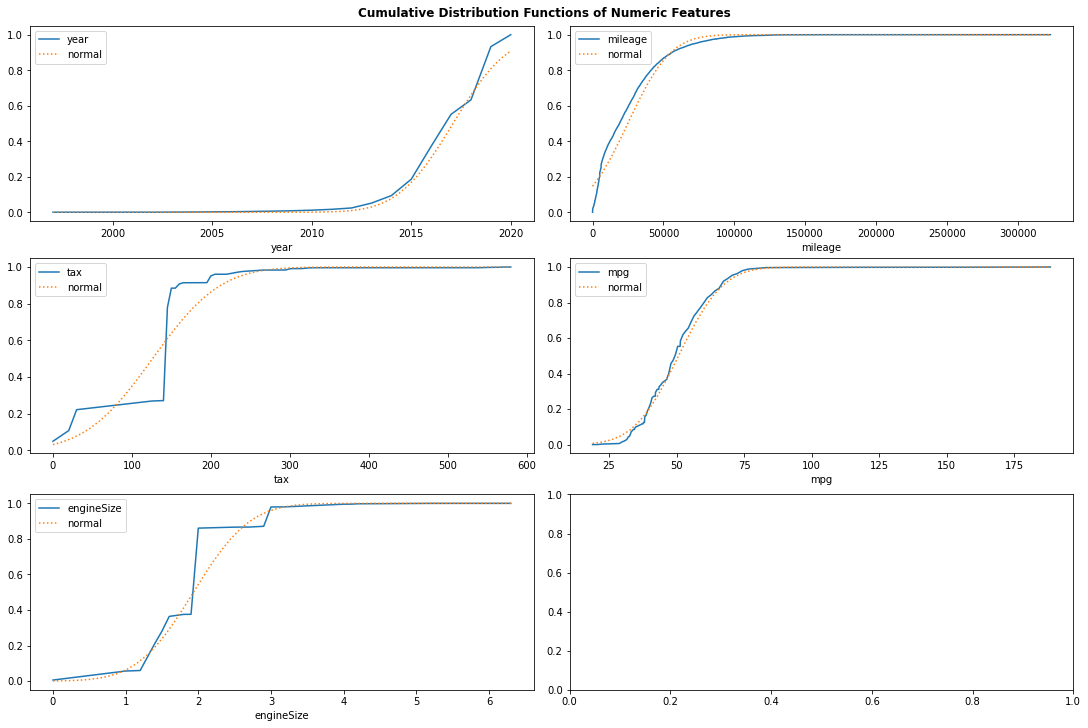

In [321]:
def plot_cdf(series, ax = None) :
    if not ax :
        _fig, ax = plt.subplots()
    ax.plot(empiricaldist.Cdf.from_seq(series), label=series.name)

    norm_dist = scipy.stats.norm(np.mean(series), np.std(series))
    xs = np.linspace(np.min(series), np.max(series))        
    ax.plot(xs, norm_dist.cdf(xs), ':', label='normal')
    
    ax.set_xlabel(series.name)
    ax.legend()

num_charts = len(NUMERIC)
num_cols = 2
num_rows = math.ceil(num_charts / 2)
fig, _ax = plt.subplots( num_rows, num_cols, 
    constrained_layout=True, figsize=(15,10), )
for i, ax in enumerate(fig.axes) :
    if i >= num_charts : 
        break
    plot_cdf( Train[NUMERIC[i]], ax)
    
_ = plt.suptitle('Cumulative Distribution Functions of Numeric Features', weight='bold')



year and mileage follow an exponential distribution.
engineSize and tax look like categories.
tax, mpg, and enginesize have positive outliers.
year has negative outliers.

1.975%  of the data are extreme upper outliers (> 3.500) for engineSize


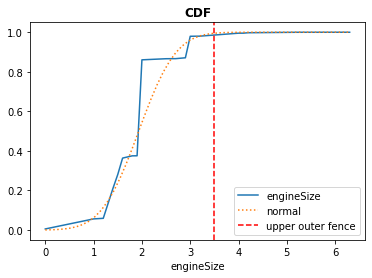

In [320]:
series = Train['engineSize']
plot_cdf(series)

iqr = np.quantile(series, 0.75) - np.quantile(series, 0.25)
fence = np.quantile(series, 0.75) + 3*iqr
plt.axvline( x=fence, ls='--', color='red', label='upper outer fence')
plt.legend()
plt.title('CDF', weight='bold')

outlier_percent = len( Train[ series > fence ]) / len(Train) * 100
print (f'{outlier_percent:.3f}%  of the data are extreme upper outliers (> {fence:.3f}) for {series.name}') 

Fence: 3.276
1.225%  of the data are extreme lower outliers (< 3.276) for log(mileage)


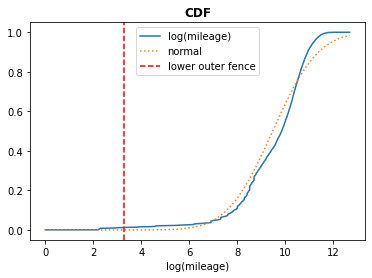

In [325]:
series = Train['mileage'].apply(lambda x : np.log(x) )
series.name = 'log(mileage)'
plot_cdf(series)

iqr = np.quantile(series, 0.75) - np.quantile(series, 0.25)
fence = np.quantile(series, 0.25) - 3*iqr
print(f'Fence: {fence:.3f}')
plt.axvline( x=fence, ls='--', color='red', label='lower outer fence')
plt.legend()
plt.title('CDF', weight='bold')
plt.xlabel('log(mileage)')

filter = Train['mileage'].apply(lambda x : np.log(x) ) < fence
outlier_percent = len( Train[ filter ]) / len(Train) * 100
print (f'{outlier_percent:.3f}%  of the data are extreme lower outliers (< {fence:.3f}) for {series.name}') 

In [279]:
print('Outliers may skew aggregations can create bias in the training model.  Remove the outliers that are a small perentage.  ')
filter = (Train['engineSize'] <= 3.5) & (Train['mileage'] <= 127000)
Train = Train[ filter ]
y_train = Train[TARGET]
Train.shape

Outliers may skew aggregations can create bias in the training model.  Remove the outliers that are a small perentage.  


(7807, 9)

## Bivariate Analysis

Let's see if the categorical variables have any correlation with the target.

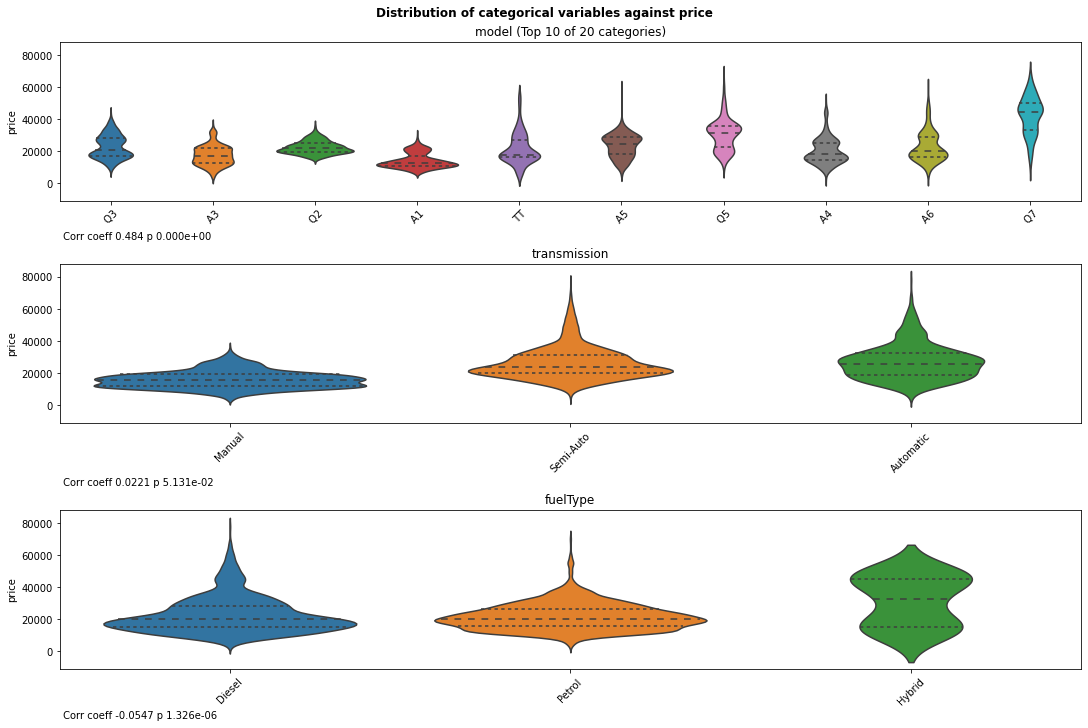

In [272]:


def violin_plot_columns_against_target(df_cat_features, y_train) :
    columns = df_cat_features.columns
    max_categories = 10
    num_cols = 1
    num_rows = math.ceil( len(columns) / 1)
    fig, _axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), constrained_layout=True, sharey=True)
    fig.suptitle('Distribution of categorical variables against price', weight='bold')

    for i, ax in enumerate(fig.axes) :
        column_name = df_cat_features.columns[i]
        if column_name == TARGET: 
            continue
        df_plot = pd.concat([df_cat_features, y_train], axis=1)

        title = column_name 
        if df_plot[column_name].nunique() > max_categories :
            title += f' (Top {max_categories} of {df_plot[column_name].nunique()} categories)'
            df_plot = df_plot[ df_plot[column_name].isin(
                df_plot[column_name].value_counts(
                )[:max_categories].index.tolist()
            ) ]
        sns.violinplot(
            x = column_name,
            y = TARGET,
            data = df_plot,
            ax = ax,
            inner='quartile',
        )
        ax.xaxis.set_tick_params(rotation=45)
        ax.set_title(title)           
        ax.set_ylabel(TARGET)
   
        coeff, p = scipy.stats.pearsonr(
            OrdinalEncoder().fit_transform(
               df_plot[[column_name]]
            ).flatten(), 
            df_plot[TARGET], 
        )

        if p < 0.1 :
            ax.set_xlabel( f' Corr coeff {coeff:0.3} p {p:.3e}', loc='left')
        else :
            ax.set_xlabel('')

        
violin_plot_columns_against_target(Train[CATEGORICAL], y_train)



The variable model has a correlation with the target.  
For transmission, manual has a lower median and IQR than the others.  
For fuelType, hybrid has a higher median and IQR than the others.  

Let's see if the numeric variables have any correlation with the target.

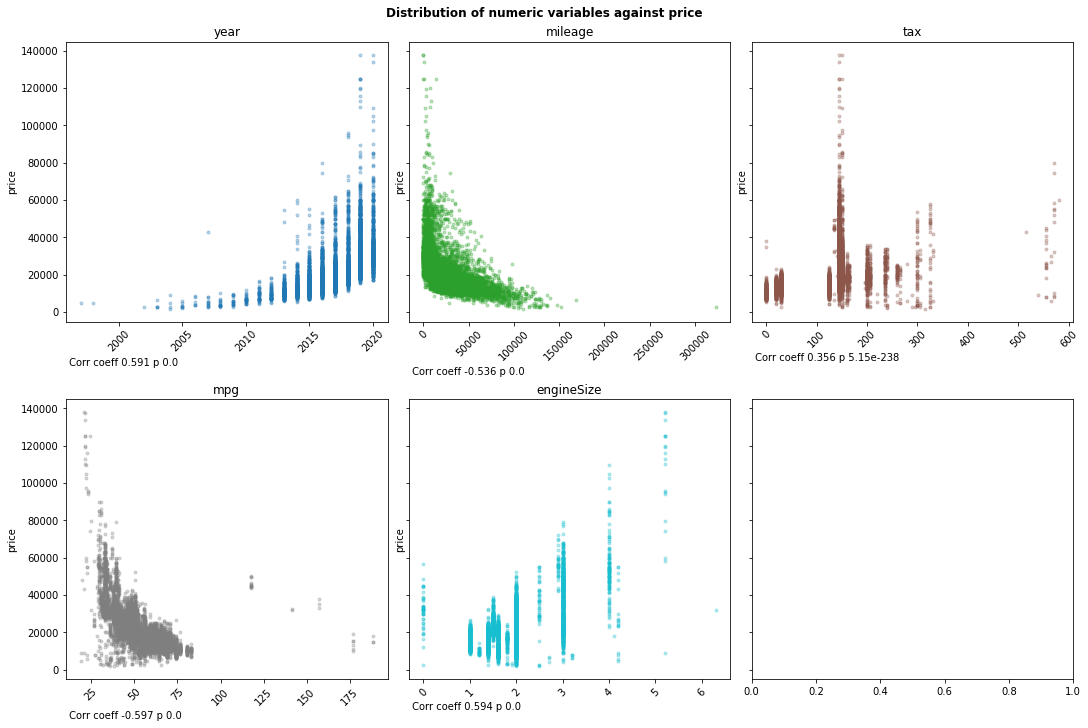

In [293]:
def scatter_plot_columns_against_target(numeric_df, y_train) :
    columns = numeric_df.columns
    num_cols = 3
    num_rows = math.ceil( len(columns) / 3)
    fig, _axes = plt.subplots(num_rows, num_cols, 
        figsize=(15, 5 * num_rows), constrained_layout=True, sharey=True)
    fig.suptitle('Distribution of numeric variables against price', weight='bold')
    
    color=iter( plt.cm.tab10( np.linspace(0,1, len(columns))))
    for i, ax in enumerate(fig.axes) :
        if i >= len(columns):
            break
        column_name = numeric_df.columns[i]
        x = numeric_df[column_name]
        # TODO outliers should have been removed, but if not they have to here
        ax.plot(x, y_train, '.', alpha=0.3, color=next(color))
        
        coeff, p = scipy.stats.pearsonr(x.to_numpy(), y_train)
        if p < 0.1 :
            ax.set_xlabel( f' Corr coeff {coeff:0.3} p {p:.3}', loc='left')
        
        ax.set_title(column_name)
        ax.xaxis.set_tick_params(rotation=45)
        ax.set_ylabel('price')

        
scatter_plot_columns_against_target(Train[NUMERIC], y_train)




There is a strong negative correlation between year and price.  
There is a strong negative correlation between mileage and price.  
There is a medium positive correlation between tax and price.  
There is a strong negative correlation between mpg and price.  
There is a medium positive correlation between engineSize and price.  

There is some multicollinearity between the variables.


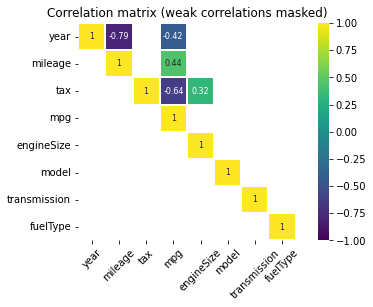

In [274]:
def plot_corr(df_numeric, cutoff = 0) :
    corr = df_numeric.corr()
    for coord in zip(*np.tril_indices_from(corr, k=-1) ): # Simplify by emptying all the data below the diagonal
        corr.iloc[coord[0], coord[1]] = np.NaN     
    corr_plot = corr[ corr.apply(lambda x : abs(x) >= cutoff) ]

    fig_height = math.ceil(len(corr.columns) / 2)
    plt.figure(figsize=(fig_height + 4, fig_height))
    g = sns.heatmap( corr_plot,
        cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
        annot=True, annot_kws={"size": 8}, square=True)
    plt.xticks(rotation=45)
    plt.title('Correlation matrix (weak correlations masked)')

ord_arr = OrdinalEncoder().fit_transform( Train[ CATEGORICAL] )
all_numeric = pd.concat([ 
        Train[NUMERIC], 
        pd.DataFrame( ord_arr, columns=CATEGORICAL, ),
    ], axis=1
)
plot_corr(all_numeric, cutoff = 0.3)
print('There is some multicollinearity between the variables.')

In [206]:
def list_correlations(df_numeric, coeff_cutoff = 0.3) :
    corr = df_numeric.corr()
    for coord in zip(*np.tril_indices_from(corr, k=-1) ): # Simplify by emptying all the data below the diagonal
        corr.iloc[coord[0], coord[1]] = np.NaN  
    df_corr_stack = (corr
                   .stack()     # Stack the data and convert to a data frame
                   .to_frame()
                   .reset_index()
                   .rename(columns={'level_0':'feature1',
                                    'level_1':'feature2',
                                    0:'correlation'}))
    df_corr_stack['abs_correlation'] = df_corr_stack.correlation.abs()
    df_large_corr_stack = df_corr_stack.loc[ np.where(
        (df_corr_stack['abs_correlation'] >= coeff_cutoff) &
        (df_corr_stack['abs_correlation'] != 1)
    )]
    
    if df_large_corr_stack.empty :
        print('*No strong correlation or anti-correlations*')
        result = df_corr_stack
    else :
        result = df_large_corr_stack
    result = result.sort_values('abs_correlation', ascending=False, 
        ).drop('abs_correlation', axis = 1)
    return result 

ord_arr = OrdinalEncoder().fit_transform( Train[ CATEGORICAL] )
all_numeric = pd.concat([ 
        Train[NUMERIC], 
        pd.DataFrame( ord_arr, columns=CATEGORICAL, ),
    ], axis=1
)
print('There is some multicollinearity between the variables.')
list_correlations(all_numeric)

There is some multicollinearity between the variables.


,feature1,feature2,correlation
1,year,mileage,-0.790440
16,tax,mpg,-0.631891
10,mileage,mpg,0.397024
17,tax,engineSize,0.395581
22,mpg,engineSize,-0.362354
3,year,mpg,-0.348293





## Multivariate Analysis

Let's see if we can drill more into the data to tighten the relationships.

We plot log(mileage) beause the mileage distribution seems to be exponential.
When controlling to cars with engineSize 1.4, there are tighter anti-correlations between log(mileage) and price.
There may be even more differentiation by model.


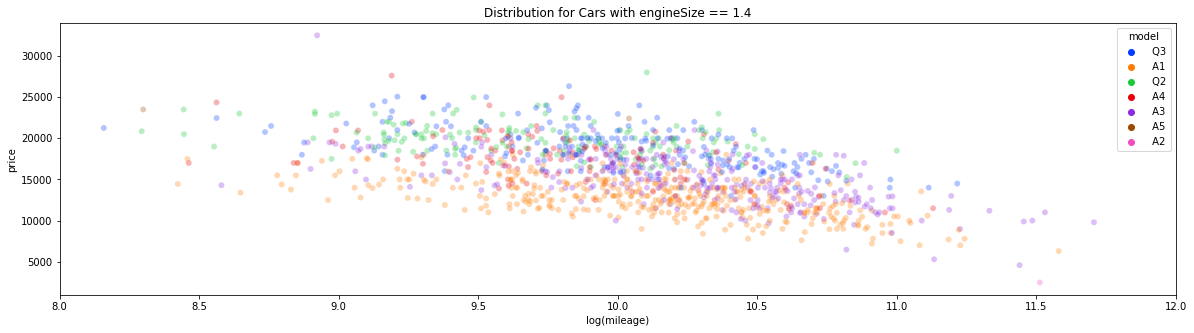

In [298]:
filter = (Train['engineSize'] == 1.4)
df_plot = Train[filter]

plt.figure(figsize=(20, 5))
sns.scatterplot( x=df_plot['mileage'].apply( lambda x : np.log(x)), 
    y=df_plot['price'], 
    hue=df_plot['model'], 
    palette='bright', alpha=0.3)
plt.xlim(8,12)
plt.xlabel('log(mileage)')
plt.title('Distribution for Cars with engineSize == 1.4')

print('We plot log(mileage) beause the mileage distribution seems to be exponential.')
print('When controlling to cars with engineSize 1.4, there are tighter anti-correlations between log(mileage) and price.')
print('There may be even more differentiation by model.')

When controlling to cars with model Q3, we see a linear negative correlation between sqrt(mileage) and price.
We can plot a regression line to show the linear collinearity.


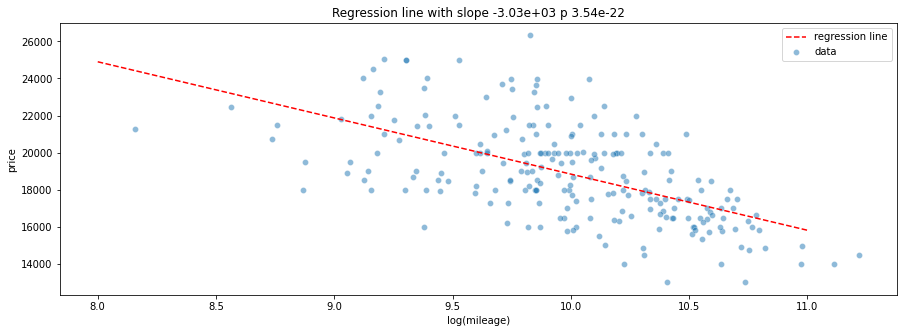

In [303]:
filter = (Train['engineSize'] == 1.4) & (Train['model'] == ' Q3')
df_plot = Train[filter]

plt.figure(figsize=(15, 5))
transformed_mileage = df_plot['mileage'].apply( lambda x : np.log(x) )
sns.scatterplot( x=transformed_mileage, y=df_plot['price'], 
    palette='bright', alpha=0.5, label='data')
plt.xlabel('log(mileage)')

regression_x = np.array([8, 11])
res = scipy.stats.linregress( transformed_mileage, df_plot['price'])
plt.plot(regression_x, res.intercept + res.slope*regression_x, 
    'r--',  label=f'regression line')

plt.title(f'Regression line with slope {res.slope:.3} p {res.pvalue:.3}')
plt.legend()
print('When controlling to cars with model Q3, we see a linear negative correlation between sqrt(mileage) and price.')
print('We can plot a regression line to show the linear collinearity.')

## Conclusion

To summarize, these are the insights drawn from the EDA:

* Used Audi cars with higher mileage tend to have lower price.  
* Cars with larger engine size tend to have higher pirce
* The car model has an effect on the price
* There is a negative linear correlation between log(mileage) and price when controlling for engineSize 1.4 and model Q3
* Cars with manual transmission have a lower price range than for other transmissions.
* Cars using hybrid fuel type have the highest price range than for other fuel types.
* Higher tax does not greatly relate to higher price
* There is multicollinearity betwen the variables, especially strong negative correlations between year and mileage, and between tax and mpg

It should be noted that although individually some variables seem unrelated to the target, their combination might have higher predictive value. Such analysis goes beyond the scope of this notebook, although any such correlations might be captured by the models trained later.
